In [1]:
import pandas as pd
import numpy as np
import random
np.random.seed(1234)
random.seed(1234)



train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/gender_submission.csv")

In [2]:
# 데이터 전처리와 특징 값 생성
# 전처리하기 전에 먼저 학습 데이터와 테스트 데이터를 통합한 데이터를 생성합니다. 이것은 학습 데이터, 테스트 
# 데이터를 모두 이용하여 전체 집계나 통계 정보를 얻기 위해서입니다.

all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [3]:
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
# 결측치 수 확인하기

all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
# 결측치 메우기(Fare)
#pclass별 Fare의 평균을 구한 후 Pclass의 평균값으로 해당 결특칠르 채우는 방법

#pclass별 Fare의 평균
Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()

In [6]:
# 열명 변경하기

Fare_mean.columns = ["Pclass", "Fare_mean"]
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [7]:
all_df = pd.merge(all_df, Fare_mean, on='Pclass', how="left")
all_df.loc[(all_df['Fare'].isnull()), 'Fare'] = all_df['Fare_mean']
all_df = all_df.drop('Fare_mean', axis=1)

In [8]:
all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

In [9]:
# Name 호칭에 주목하기

all_df['Name'].head(5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [10]:
# Name을 str을 써서 문자열로 취득한 후 split()를 사용하여 쉼표나 마침표로 구분하면 0부터 세기 시작해서 2번째에 
# 나오는 요소가 호칭이 된다.
name_df = all_df['Name'].str.split("[,.]", 2, expand=True)
name_df

,0,1,2
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [11]:
# 열명 변경하기

name_df.columns = ['family_name', 'honorific', 'name']

In [12]:
name_df

,family_name,honorific,name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [13]:
name_df['family_name'] = name_df['family_name'].str.strip()
name_df['honorific'] = name_df['honorific'].str.strip()
name_df['name'] = name_df['name'].str.strip()

In [14]:
name_df

,family_name,honorific,name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [15]:
# 호칭마다 인원 수 세기

name_df['honorific'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: honorific, dtype: int64

In [16]:
# 호칭 별 연령 분포 확인하기
# 먼저 all_df와 name_df를 결합합니다.

all_df = pd.concat([all_df, name_df], axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick


<AxesSubplot:xlabel='honorific', ylabel='Age'>

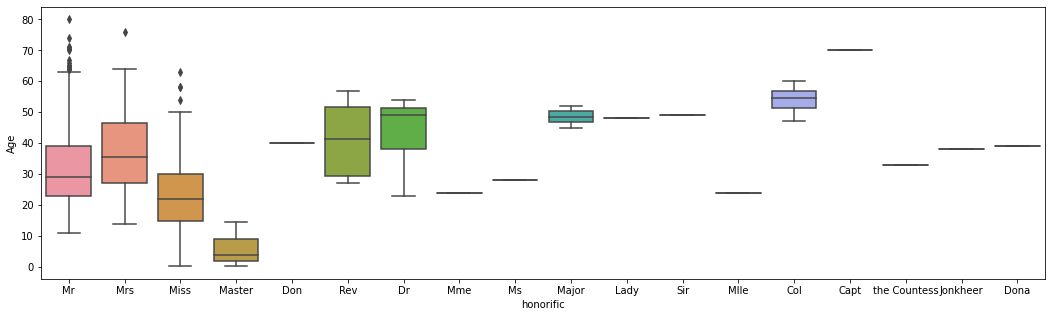

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,5))
sns.boxplot(x='honorific', y='Age', data=all_df)

In [18]:
# 호칭별 연령 평균값

all_df[['Age', 'honorific']].groupby('honorific').mean()

,Age
honorific,
Capt,70.000000
Col,54.000000
Don,40.000000
Dona,39.000000
Dr,43.571429
Jonkheer,38.000000
Lady,48.000000
Major,48.500000
Master,5.482642


In [19]:
# 호칭별 생존율 차이 확인하기
# 원래 데이터프레임에 이름으로 만든 데이터프레임 결합하기

train_df = pd.concat([train_df, name_df[0:len(train_df)].reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df, name_df[len(train_df):].reset_index(drop=True)], axis=1)

In [20]:
# 호칭별로 생존 여부 집계하기

honorific_df = train_df[['honorific', 'Survived', 'PassengerId']].dropna().groupby(['honorific', 'Survived']).count().unstack()

<AxesSubplot:xlabel='honorific'>

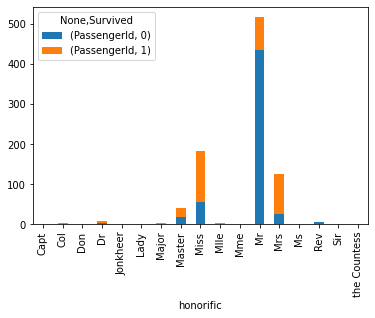

In [21]:
honorific_df.plot.bar(stacked=True)

In [22]:
honorific_age_mean = all_df[['honorific', 'Age']].groupby("honorific").mean().reset_index()

In [23]:
honorific_age_mean

,honorific,Age
0,Capt,70.000000
1,Col,54.000000
2,Don,40.000000
3,Dona,39.000000
4,Dr,43.571429
5,Jonkheer,38.000000
6,Lady,48.000000
7,Major,48.500000
8,Master,5.482642
9,Miss,21.774238


In [24]:
honorific_age_mean.columns = ['honorific', 'honorific_Age']
honorific_age_mean.head(5)


,honorific,honorific_Age
0,Capt,70.000000
1,Col,54.000000
2,Don,40.000000
3,Dona,39.000000
4,Dr,43.571429


In [25]:
all_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,name
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


In [26]:
all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how='left')
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,name,honorific_Age
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,32.252151
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),36.994118
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,21.774238
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),36.994118
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry,32.252151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,32.252151
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina,39.000000
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,32.252151
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr,Frederick,32.252151


In [27]:
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df['honorific_Age']

In [28]:
all_df = all_df.drop(['honorific_Age'], axis=1)

In [29]:
# 호칭별 평균 연령으로 연령에 결손된 곳을 보충해주었음

all_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
family_name       0
honorific         0
name              0
dtype: int64

In [30]:
# 가족 인원수 추가하기
# 이 데이터에서는 parch(승선 중인 부모나 자녀의 수)와 SibSp(승선 중인 형제나 배우자의 수)라는 가족과 관련한 변수가
# 두개 포함되어 있다. 따라서 우선 이들 변수를 더해 family_num을 만들어 보자

all_df['family_num'] = all_df['Parch'] + all_df['SibSp']
all_df['family_num'].value_counts()

0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: family_num, dtype: int64

In [31]:
# 가족 인원수를 확인하면 함께 배에 탄 가족 수가 0명, 즉 1명이 승선한 경우가 절반 이상이다.
# 타이타닉호의 조난과 같은 상황이라면 가족이 함께 행동했을 확률이 높다
# 따라서 1명인지 아님녀 같은 승선 가족이 있는가 생존에 영향을 줄 수 있다는 가능성이 있으므로
# alone -> 1 그렇지 않으면 0이라는 변수를 준다

all_df.loc[all_df['family_num']==0, "alone"] = 1
all_df['alone'].fillna(0, inplace=True)

In [32]:
all_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,honorific,name,family_num,alone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,1,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),1,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),1,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry,0,1.0


In [33]:
# 불필요한 변수 삭제하기

all_df = all_df.drop(['PassengerId', 'Name', 'family_name', 'name', 'Ticket', 'Cabin'], axis=1)

In [34]:
all_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1,0.0
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1,0.0
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0,1.0
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1,0.0
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,0,1.0


In [35]:
# 카테고리 변수를 수치로 변환하기
# 또 여러 카테고리 변수 중 문자열은 수치로 변환합니다. 우선은 변수 형태가 object인 것을 카테고리 변수로 관리

categories = all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['Sex', 'Embarked', 'honorific'], dtype='object')


In [36]:
# Mr, Miss, Mrs, Master 이외는 other로 통합하기

all_df.loc[~((all_df['honorific'] == 'Mr') | (all_df['honorific'] == 'Miss') | (all_df['honorific']=='Mrs') | (all_df['honorific'] == 'Master')), 'honorific'] = "other"

In [37]:
all_df.honorific.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: honorific, dtype: int64

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
# 라벨 인코딩
# LabelEncoder는 결측치가 있으면 작동하지 않기 때문에 Embarked에 포함된 결측치는 missing 등 임의의 문자열로 미리 치환해야 한다.

all_df['Embarked'].fillna("missing", inplace=True)

In [40]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    if all_df[cat].dtypes == "object":
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])

Sex
Embarked
honorific


In [41]:
all_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,1,22.0,1,0,7.2500,2,2,1,0.0
1,1.0,1,0,38.0,1,0,71.2833,0,3,1,0.0
2,1.0,3,0,26.0,0,0,7.9250,2,1,0,1.0
3,1.0,1,0,35.0,1,0,53.1000,2,3,1,0.0
4,0.0,3,1,35.0,0,0,8.0500,2,2,0,1.0


In [42]:
all_df[~all_df["Survived"].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,1,22.000000,1,0,7.2500,2,2,1,0.0
1,1.0,1,0,38.000000,1,0,71.2833,0,3,1,0.0
2,1.0,3,0,26.000000,0,0,7.9250,2,1,0,1.0
3,1.0,1,0,35.000000,1,0,53.1000,2,3,1,0.0
4,0.0,3,1,35.000000,0,0,8.0500,2,2,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,27.000000,0,0,13.0000,2,4,0,1.0
887,1.0,1,0,19.000000,0,0,30.0000,2,1,0,1.0
888,0.0,3,0,21.774238,1,2,23.4500,2,1,3,0.0
889,1.0,1,1,26.000000,0,0,30.0000,0,2,0,1.0


In [43]:
# 이제 모든 열을 수치 데이터로 만들었다. 마지막으로 모든 데이터를 다시 학습 데이터와 테스트 데이터로 되돌려 놓겠다.
# survived 값이 null이 아닐 때는 학습 데이터로 하고, null일 때는 테스트 데이터로 합니다. 
# survived 이외의 변수를 설명 변수(train_x, test_x)로 하고, survived 값을 목적 변수(train_y)로 하겠다.

train_x = all_df[~all_df['Survived'].isnull()].drop("Survived", axis=1).reset_index(drop=True)

train_y = train_df['Survived']

test_x = all_df[all_df['Survived'].isnull()].drop("Survived", axis=1).reset_index(drop=True)

In [44]:
# LightGBM 

import lightgbm as lgb

In [45]:
# 홀드 아웃, 교차 검증 실습

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [46]:
# 학습 데이터의 20%를 검증 데이터로 분활하기

X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2)

In [47]:
# LightGBM용 데이터셋 작성하기
# X_train, y_train 데이터로 모델을 학습하고 X_valid의 예측 정확도를 확인하겠다.

# 먼저 카테고리 변수를 지정한 후 LightGBM용 데이터셋을 작성한다.

categories = ['Embarked', 'Pclass', 'Sex', 'honorific', 'alone']

In [48]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

In [49]:
# 하이퍼파라미터 설정하기

lgbm_params = {
    "objective":"binary",
    "max_bin":330,
    "num_leaves":10,
    "min_data_in_leaf":50,
    "random_seed":1234
}

In [50]:
from platform import python_version

print(python_version())

3.9.7


In [51]:
# LightGBM으로 머신 러닝 모델 학습시키기
# num_boost_round -> 학습 횟수
# early_stopping_rounds -> 학습할 때 몇 번 연속으로 
#결과가 개선되지 않으면 학습을 중지할지
# verbose_eval -> 학습 결과의 표시 빈도를 지정한다. 
model_lgb = lgb.train(lgbm_params,
                     lgb_train,
                     valid_sets=lgb_eval,
                     num_boost_round =100,
                     early_stopping_rounds=20,
                     verbose_eval=10)

[LightGBM] [Info] Number of positive: 272, number of negative: 440
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382022 -> initscore=-0.480973
[LightGBM] [Info] Start training from score -0.480973
Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.466739
[20]	valid_0's binary_logloss: 0.414773
[30]	valid_0's binary_logloss: 0.394162
[40]	valid_0's binary_logloss: 0.392532
[50]	valid_0's binary_logloss: 0.395802
[60]	valid_0's binary_logloss: 0.400956
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.391815


C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

In [52]:
# 어떤 설명 변수가 얼마나 중요한 역할을 했는지 알아보자
# 몇 번째 열이 중요했는지 알 수 있다. 
# 각 열명을 표시하려면 index=X_train.columns를 사용한다.
model_lgb.feature_importance()

array([ 36,  13, 112,   9,   2, 136,  20,  21,  27,   2])

In [53]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, 
                          columns=['importance']).sort_values(by="importance", ascending=True)

<AxesSubplot:>

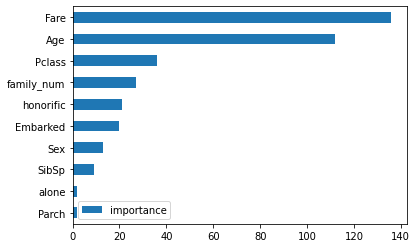

In [54]:
importance.plot.barh()

In [55]:
# Fare, Age에 이어 Pclass 등이 중요한 변수로 파악되었다. 
# 어린아이들이 우선적으로 구조되었을 가능성이 있고, 상위 클래스 고객(plcass,fare)이 우선적으로 구조되었을
# 가능성이 있다.

In [56]:
# 검증 데이터로 예측 정확도 확인
#.predict() 인수를 넣고, 모델명.best_iteration이라고 지정하면 정확도가 가장 높은 때의 학습 모델을 사용하여 
# 예측한다.

y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
y_pred

array([0.95557734, 0.08431721, 0.08851175, 0.93073865, 0.42717925,
       0.41334908, 0.47884496, 0.47478412, 0.18635583, 0.17858441,
       0.73150828, 0.05502086, 0.07918994, 0.12048899, 0.19778689,
       0.18635583, 0.14583616, 0.47217629, 0.13276695, 0.0488654 ,
       0.04918844, 0.47312107, 0.95207603, 0.13549695, 0.887313  ,
       0.09738391, 0.32877133, 0.93888422, 0.7228303 , 0.04343552,
       0.08639731, 0.36268067, 0.40697658, 0.94351836, 0.59648078,
       0.3435749 , 0.1119762 , 0.10603391, 0.32813919, 0.48971829,
       0.09282609, 0.92678513, 0.95285745, 0.08419559, 0.1157532 ,
       0.47404878, 0.04783412, 0.08314769, 0.16914669, 0.92441731,
       0.96106001, 0.0552154 , 0.21333806, 0.08471611, 0.51479198,
       0.3827274 , 0.05906947, 0.10569419, 0.05451002, 0.05190286,
       0.21312862, 0.68630775, 0.9393808 , 0.90188411, 0.08399304,
       0.94841167, 0.65522911, 0.13069901, 0.08242162, 0.05064286,
       0.52554271, 0.17124177, 0.04783412, 0.0565635 , 0.04425

In [57]:
# 예측 정확도 출력하기

# 정확도를 계산하는 라이브러리 불러오기

from sklearn.metrics import accuracy_score

accuracy_score(y_valid, np.round(y_pred))
# 검증 데이터로 현재 모델이 0.826~의 정확도를 보이고 있음을 확인하였다.

0.8547486033519553

In [58]:
folds = 3
kf = KFold(n_splits=folds)


In [59]:
models=[]

for train_index, val_index in kf.split(train_x):
    X_train = train_x.iloc[train_index]
    X_valid = train_x.iloc[val_index]
    y_train = train_y.iloc[train_index]
    y_valid = train_y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_train, y_train, categorical_feature=categories, reference=lgb_train)
    
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         num_boost_round = 100,
                         early_stopping_rounds = 20,
                         verbose_eval =10)
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    models.append(model_lgb)

[LightGBM] [Info] Number of positive: 236, number of negative: 358
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 594, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397306 -> initscore=-0.416701
[LightGBM] [Info] Start training from score -0.416701
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sonsj\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Ref

In [60]:
# 테스트 데이터의 결과를 예측하여 저장하기

preds = []

for model in models:
    pred = model.predict(test_x)
    preds.append(pred)

In [61]:
# 예측결과 평균 구하기

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [62]:
# 0이나 1로 변환하기

preds_int = (preds_mean > 0.5).astype(int)

In [63]:
# Survived 파일의 Survived 값 치환하기

submission['Survived'] = preds_int
submission.shape

(418, 2)

In [64]:
# 생존자수 세어보았음
# 418명 중에 151명이 생존했을 것이다.
submission['Survived'].sum()

151

In [65]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [66]:
submission.to_csv("./submit/titanic_submit01.csv", index=False)